# Load dataset QM9

This is a test script to load and display molecules of the QM9 dataset.

In [3]:
import tensorflow 
import os
import urllib
import numpy as np
import tarfile

In [9]:
def qm9_prepare_molecule(lines):
    pt = {"C": 6, "H": 1, "O": 8, "N": 7, "F": 9}
    
    N = int(lines[0]) # Nombre d'atomes
    
    elements = [pt[line.split()[0]] for line in lines[2:N + 2]]
    
    coords = np.empty((N, 3), dtype=np.float64)
    charges = np.empty(N, dtype=np.float64)
    
    for i in range(N):
        values = [float(x.replace('*^', 'e')) for x in lines[i + 2].split()[1:]]
        coords[i] = values[:3]  # x, y, z
        charges[i] = values[3]   # Charge de Mulliken
    
    return {
        "N": N,
        "elements": elements,
        "coords": coords,
        "charges": charges
    }


def qm9_fetch():
    """
    Télécharge et prépare le dataset QM9.
    """
    RAW_FILE = "qm9.tar.bz2"
    QM9_URL = "https://ndownloader.figshare.com/files/3195389"
    NUM_MOLECULES = 10 # 133885
    
    
    if not os.path.isfile(RAW_FILE): # Télécharger l'archive si nécessaire
        print("Téléchargement du dataset QM9...")
        urllib.request.urlretrieve(QM9_URL, RAW_FILE)
        print("Téléchargement terminé")
    else:
        print(f"Archive {RAW_FILE} existante")
    
    
    molecules = []
    with tarfile.open(RAW_FILE, "r:bz2") as tar:
        for i in range(1, NUM_MOLECULES + 1):
            if i % 100 == 0:
                progress = (i / NUM_MOLECULES) * 100
                print(f"\rProgression: {progress:.1f}%", end="", flush=True)
            
            # Extraire et parser chaque molécule
            filename = f"dsgdb9nsd_{i:06d}.xyz"
            
            try:
                with tar.extractfile(filename) as f:
                    lines = [line.decode("UTF-8") for line in f.readlines()]
                    molecule = qm9_prepare_molecule(lines)
                    molecules.append(molecule)
                    
            except (ValueError, KeyError) as e:
                print(f"\nErreur lors du traitement de la molécule {i}: {e}")
                raise e
    
    print(f"\nExtraction terminée ! {len(molecules)} molécules chargées.")
    return molecules

In [10]:
molecules = qm9_fetch()

Archive qm9.tar.bz2 existante

Extraction terminée ! 10 molécules chargées.


In [11]:
print(molecules[0])

{'N': 5, 'elements': [6, 1, 1, 1, 1], 'coords': array([[-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
       [ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03],
       [ 1.01173084e+00,  1.46375116e+00,  2.76574800e-04],
       [-5.40815069e-01,  1.44752661e+00, -8.76643715e-01],
       [-5.23813634e-01,  1.43793264e+00,  9.06397294e-01]]), 'charges': array([-0.535689,  0.133921,  0.133922,  0.133923,  0.133923])}


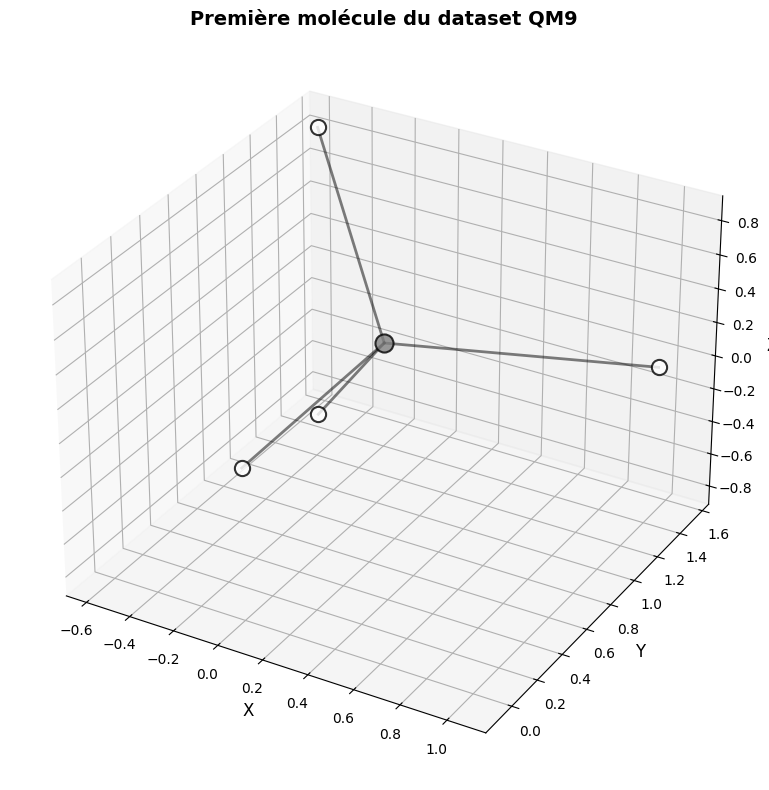

In [17]:
import matplotlib.pyplot as plt
import numpy as np


def plot_molecule(molecule, title="Molécule", show_charges=False, figsize=(10, 8)):
    element_colors = { # Couleurs CPK (Corey-Pauling-Koltun) standard pour les éléments
        1: '#FFFFFF',   # H - Blanc
        6: '#808080',   # C - Gris
        7: '#0000FF',   # N - Bleu
        8: '#FF0000',   # O - Rouge
        9: '#90E050',   # F - Vert clair
    }
    element_names = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F'} # Noms des éléments
    element_sizes = {1: 120, 6: 170, 7: 155, 8: 152, 9: 147} # Rayons de van der Waals
    
    # Créer la figure 3D
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    coords = molecule['coords']
    elements = molecule['elements']
    charges = molecule['charges']
    
    # Tracer chaque atome
    for i, (coord, element, charge) in enumerate(zip(coords, elements, charges)):
        color = element_colors.get(element, '#FF1493')  # Rose par défaut si élément inconnu
        size = element_sizes.get(element, 150)
        name = element_names.get(element, f'Z={element}')
        
        label = f"{name}"
        if show_charges:
            label += f" (q={charge:.2f})"
        
        ax.scatter(coord[0], coord[1], coord[2], 
                  c=color, s=size, alpha=0.8, 
                  edgecolors='black', linewidth=1.5,
                  label=label if i == 0 or elements[i] != elements[i-1] else "")
    
    # Tracer les liaisons (simple heuristique basée sur la distance)
    max_bond_distance = 1.3  # Angströms
    
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            distance = np.linalg.norm(coords[i] - coords[j])
            if distance < max_bond_distance:
                ax.plot([coords[i][0], coords[j][0]],
                       [coords[i][1], coords[j][1]],
                       [coords[i][2], coords[j][2]],
                       'k-', linewidth=2, alpha=0.5)
    
    # Configuration du graphique
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    
    # Aspect ratio égal pour une meilleure visualisation
    max_range = np.array([coords[:, 0].max() - coords[:, 0].min(),
                         coords[:, 1].max() - coords[:, 1].min(),
                         coords[:, 2].max() - coords[:, 2].min()]).max() / 2.0
    
    mid_x = (coords[:, 0].max() + coords[:, 0].min()) * 0.5
    mid_y = (coords[:, 1].max() + coords[:, 1].min()) * 0.5
    mid_z = (coords[:, 2].max() + coords[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.tight_layout()
    return fig, ax


def plot_multiple_molecules(molecules, n_molecules=6, cols=3, figsize=(15, 10)):
    """
    Visualise plusieurs molécules dans une grille.
    
    Args:
        molecules: Liste de molécules
        n_molecules: Nombre de molécules à afficher
        cols: Nombre de colonnes dans la grille
        figsize: Taille de la figure
    """
    rows = (n_molecules + cols - 1) // cols
    fig = plt.figure(figsize=figsize)
    
    element_colors = {1: '#FFFFFF', 6: '#808090', 7: '#0000FF', 8: '#FF0000', 9: '#90E050'}
    element_sizes = {1: 80, 6: 120, 7: 110, 8: 110, 9: 105}
    
    for idx in range(min(n_molecules, len(molecules))):
        ax = fig.add_subplot(rows, cols, idx + 1, projection='3d')
        
        molecule = molecules[idx]
        coords = molecule['coords']
        elements = molecule['elements']
        
        # Tracer les atomes
        for coord, element in zip(coords, elements):
            color = element_colors.get(element, '#FF1493')
            size = element_sizes.get(element, 100)
            ax.scatter(coord[0], coord[1], coord[2], 
                      c=color, s=size, alpha=0.9,
                      edgecolors='black', linewidth=1)
        
        # Tracer les liaisons
        max_bond_distance = 0.4
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                distance = np.linalg.norm(coords[i] - coords[j])
                if distance < max_bond_distance:
                    ax.plot([coords[i][0], coords[j][0]],
                           [coords[i][1], coords[j][1]],
                           [coords[i][2], coords[j][2]],
                           'k-', linewidth=1.5, alpha=0.4)
        
        ax.set_title(f'Molécule {idx + 1} ({molecule["N"]} atomes)', fontsize=10)
        ax.set_xlabel('X', fontsize=8)
        ax.set_ylabel('Y', fontsize=8)
        ax.set_zlabel('Z', fontsize=8)
        ax.tick_params(labelsize=7)
    
    plt.tight_layout()
    return fig


plot_molecule(molecules[0], title="Première molécule du dataset QM9", show_charges=True)
plt.show()
